In [1]:
Output = ('/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1011. Emission Mixtures/P1011.3. Analyses/P1011.3.3. Biomarker Cluster Analysis/Output')
cur_date = "112923"

library(readxl)
library(tidyverse)
library(reshape2)
library(factoextra)
library(gridExtra)
library(ggrepel)
library(pheatmap)

# reading in files
cytokine_df = data.frame(read_excel("Input/Processed_Cytokine_Data_081723.xlsx"))
mRNA_df = data.frame(read_excel("Input/Processed_mRNA_Data_081723.xlsx"))

# making some cols numeric
cytokine_df$Condensate_Conc = as.numeric(cytokine_df$Condensate_Conc)
mRNA_df$Concentration = as.numeric(mRNA_df$Concentration)
mRNA_df$Time_Point = as.numeric(mRNA_df$Time_Point)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”
Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


In [2]:
head(mRNA_df)
head(cytokine_df)

,Subject_No,Subject_ID,mRNA,Condensate,Burn_Condition,Concentration,Time_Point,Norm_ddCT
,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,6,M_6,HMOX1,PBS,PBS,NA,24,3.912311
2,5,F_5,HMOX1,PBS,PBS,NA,4,3.067190
3,1,F_1,HMOX1,PBS,PBS,NA,4,3.843045
4,2,M_2,HMOX1,PBS,PBS,NA,4,3.415457
5,3,M_3,HMOX1,PBS,PBS,NA,4,3.234524
6,4,F_4,HMOX1,PBS,PBS,NA,4,3.294681


,Subject_ID,Subject_No,Cytokine,Condensate,Burn_Condition,Condensate_Conc,Norm_Cytokine_Conc
,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,F_1,1,Eotaxin3,C,F,1,5.438924
2,F_1,1,Eotaxin3,C,F,25,3.630025
3,F_1,1,Eotaxin3,C,F,5,4.694272
4,F_1,1,Eotaxin3,C,S,1,6.165522
5,F_1,1,Eotaxin3,C,S,25,3.703871
6,F_1,1,Eotaxin3,C,S,5,4.562595


This analysis will use PCA to explore if there are clusters of sample conditions that condensate, burn condition, and the time point. PCA will be run initially and the eigenvector values will be averaged within each sample condition to improve the visualization and elucidate any clusters that may arise. 

The second part of this analysis will leverage hierarchical clustering to determine if specific biomarkers cluster. The gene expression analysis will be further stratified by time point (4 and 24hrs). 

# Principal Component Analysis (PCA)

In [3]:
# creating 1 df and casting wide
wider_mRNA_df = mRNA_df %>%
    # creating a column that denotes the biomarker
    mutate(Biomarker = "mRNA") %>%
    # removing the subject no since that messes up pivoting
    select(-Subject_No) %>%
    # creating sample ids
    unite("SampleID", c(colnames(mRNA_df)[c(3:7)]), remove = FALSE) %>%
    pivot_wider(names_from = "Subject_ID", values_from = "Norm_ddCT") %>%
    # keeping 4,24 hr time point, removing concentration of 5 and 1
    filter(Time_Point %in% c(4,24), Concentration %in% c(25,NA)) %>%
    column_to_rownames(var = "SampleID") 

wider_cytokine_df = cytokine_df %>%
    # creating a column that denotes the biomarker
    mutate(Biomarker = "Cytokine") %>%
    # removing the subject no since that messes up pivoting
    select(-Subject_No) %>%
    # creating sample ids
    unite("SampleID", c(colnames(cytokine_df)[c(3:6)]), remove = FALSE) %>%
    pivot_wider(names_from = "Subject_ID", values_from = "Norm_Cytokine_Conc") %>%
    # removing concentration of 5 and 1
    filter(Condensate_Conc %in% c(25,NA)) %>%
    column_to_rownames(var = "SampleID") 

head(wider_mRNA_df)
head(wider_cytokine_df)

,mRNA,Condensate,Burn_Condition,Concentration,Time_Point,Biomarker,M_6,F_5,F_1,M_2,M_3,F_4
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
HMOX1_PBS_PBS_NA_24,HMOX1,PBS,PBS,NA,24,mRNA,3.912311,-14.276188,-14.4683669,-14.2478117,-14.4096419,-13.94705692
HMOX1_PBS_PBS_NA_4,HMOX1,PBS,PBS,NA,4,mRNA,3.820872,3.067190,3.8430445,3.4154567,3.2345242,3.29468128
HMOX1_C_F_25_4,HMOX1,C,F,25,4,mRNA,-10.072194,-1.365144,-16.2508970,2.4192352,1.6632660,1.17018046
HMOX1_C_S_25_4,HMOX1,C,S,25,4,mRNA,-16.998608,1.798422,0.7883619,-1.1610217,0.1780591,1.29378688
HMOX1_P_F_25_4,HMOX1,P,F,25,4,mRNA,2.464774,-16.941843,2.0417508,0.9382362,-0.7053270,0.07733123
HMOX1_P_S_25_4,HMOX1,P,S,25,4,mRNA,-14.786717,-15.002740,-18.4750119,-15.6629303,-3.8789395,-17.61538360


,Cytokine,Condensate,Burn_Condition,Condensate_Conc,Biomarker,F_1,M_2,M_3,F_4,F_5,M_6
,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Eotaxin3_C_F_25,Eotaxin3,C,F,25,Cytokine,3.630025,4.340598,3.506399,2.337052,1.618586,-1.993679
Eotaxin3_C_S_25,Eotaxin3,C,S,25,Cytokine,3.703871,4.272783,2.546582,1.805488,2.116017,1.545123
Eotaxin3_P_F_25,Eotaxin3,P,F,25,Cytokine,2.263359,3.026700,4.033679,2.680696,2.931078,1.725753
Eotaxin3_P_S_25,Eotaxin3,P,S,25,Cytokine,3.168227,4.778556,3.000664,1.335493,2.099569,1.561915
Eotaxin3_PBS_PBS_NA,Eotaxin3,PBS,PBS,NA,Cytokine,2.930862,1.626444,3.757961,3.429681,1.933228,2.596697
GMCSF_C_F_25,GMCSF,C,F,25,Cytokine,3.259669,1.675726,2.825662,3.005677,1.860076,1.495912


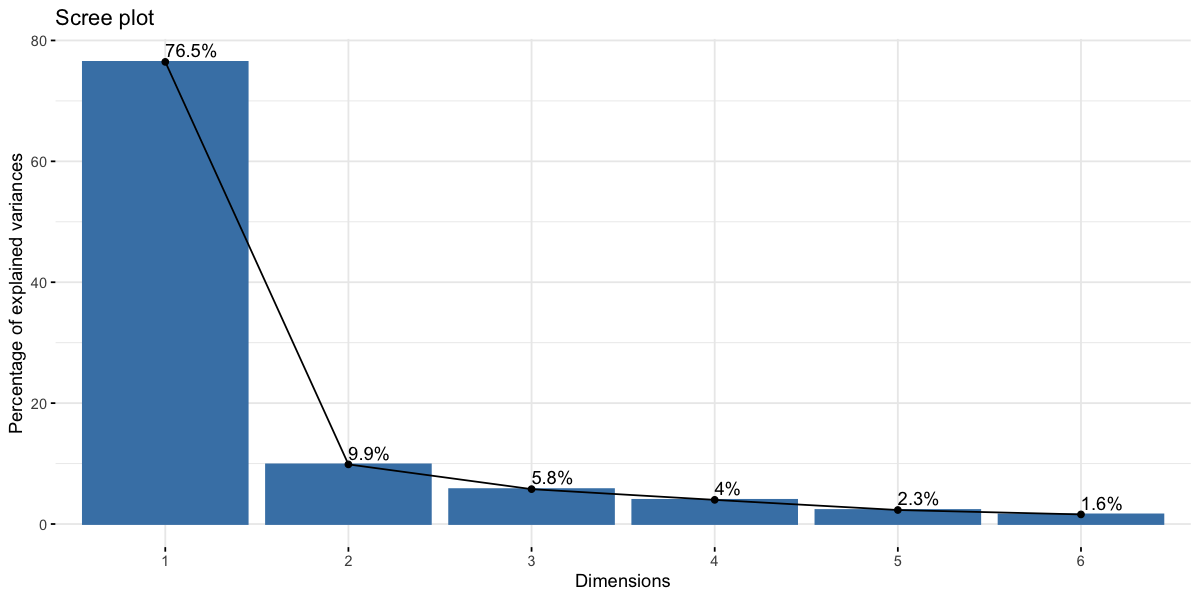

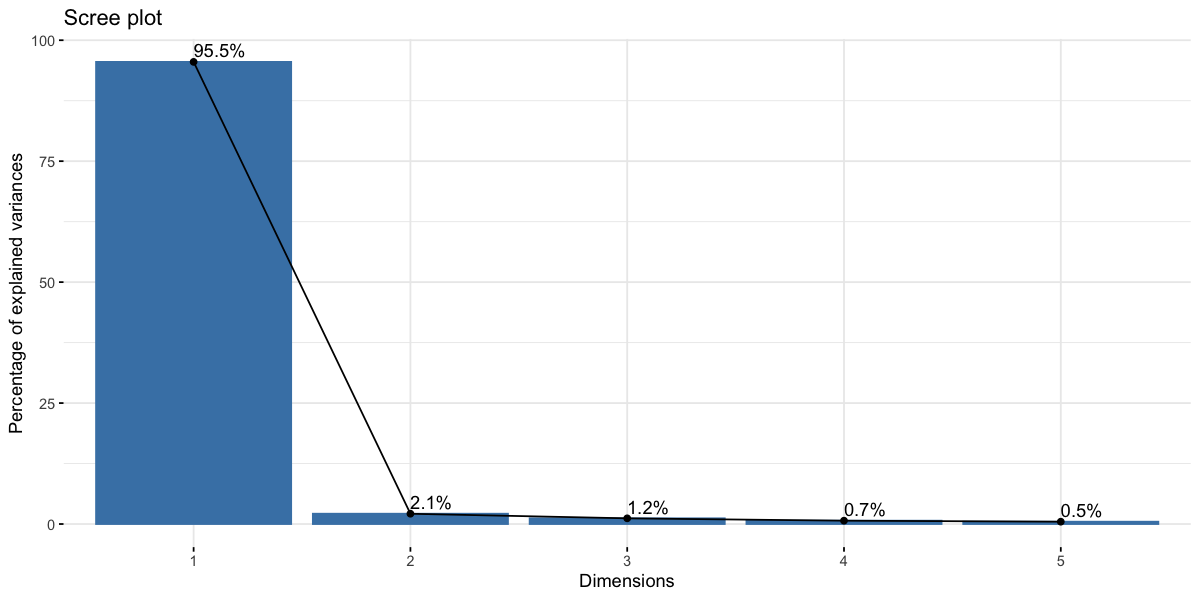

In [4]:
# running pca 
mRNA_pca = prcomp(wider_mRNA_df[,7:12], center = TRUE)
cytokine_pca = prcomp(wider_cytokine_df[,7:11], center = TRUE)

# looking a scree plot to see how much of the variance was captured in the first 2 eigenvectors
options(repr.plot.width = 10, repr.plot.height = 5) #changing size
fviz_eig(mRNA_pca, addlabels = TRUE)
fviz_eig(cytokine_pca, addlabels = TRUE)

The standard way to detect outliers in genetics is the criterion of being “more than 6 standard deviations away from the mean”. [source](https://privefl.github.io/blog/detecting-outlier-samples-in-pca/)

In [5]:
outlier_detection = function(pca_df){
    # """
    # Creating a scoring function for to detect PCA sample outliers. 
    # :param (input): PCA df (df)
    # :output: outlier names
    # """
    
    # getting scores
    scores = pca_df$x
    # identifying samples that are > 6 standard deviations away from the mean
    outlier_indices = apply(scores, 2, function(x) which( abs(x - mean(x)) > (6 * sd(x)) )) %>%
        Reduce(union, .)
    # getting sample names
    outliers = rownames(scores)[outlier_indices]
    
    return(outliers)
}

# calling fn
mRNA_outliers = outlier_detection(mRNA_pca)  
cytokine_outliers = outlier_detection(cytokine_pca)  

In [6]:
# getting length
length(mRNA_outliers)
length(cytokine_outliers)

[1] 0

[1] 0

There were no outliers, so the next chunk of code isn't necessary.

In [7]:
# # going back to remove outliers
# `%notin%` <- Negate(`%in%`)
# no_outliers_FC_mRNA_df = wider_FC_mRNA_df[row.names(wider_FC_mRNA_df)%notin% mRNA_outliers,]
# no_outliers_FC_cytokine_df = wider_FC_cytokine_df[row.names(wider_FC_cytokine_df)%notin% cytokine_outliers,]

# # rerunning pca 
# no_outliers_mRNA_pca = prcomp(no_outliers_FC_mRNA_df[,7:12], center = TRUE)
# no_outliers_cytokine_pca = prcomp(no_outliers_FC_cytokine_df[,7:11], center = TRUE)

# # looking a scree plot to see how much of the variance was captured in first 2 eigenvectors
# options(repr.plot.width = 10, repr.plot.height = 5) #changing size
# fviz_eig(no_outliers_mRNA_pca, addlabels = TRUE)
# fviz_eig(no_outliers_cytokine_pca, addlabels = TRUE)

In [8]:
# creating 1 df with eigenvectors, normalized values, condensate, burn condition data
mRNA_pca_df = data.frame(mRNA_pca$x[,1:2]) %>%
               rownames_to_column(var = "Name_Sample_ID") 
cytokine_pca_df = data.frame(cytokine_pca$x[,1:2]) %>%
               rownames_to_column(var = "Name_Sample_ID") 

more_data_biomarker_df = full_join(wider_mRNA_df[,1:6] %>% 
                                    rename(Biomarker_Name = mRNA) %>%
                                    rownames_to_column(var = "Name_Sample_ID"), 
                                wider_cytokine_df[,1:5] %>% 
                                    rename(Biomarker_Name = Cytokine, Concentration = Condensate_Conc) %>%
                                    mutate(Time_Point = 24) %>%
                                    rownames_to_column(var = "Name_Sample_ID")) 

full_eigenvector_df = inner_join(rbind(mRNA_pca_df, cytokine_pca_df), 
                                             more_data_biomarker_df) %>%
    # adding a sample id without the biomarker's name
    unite("Sample_ID", c(colnames(more_data_biomarker_df)[c(3:6)]), remove = FALSE) %>%
    # and taking average eigenvector value within each group
    group_by(Biomarker, Sample_ID) %>%
    summarize(Avg_PC1 = mean(PC1), Avg_PC2 = mean(PC2)) %>%
    # cleaning up sample id names for plotting
    mutate(Sample_ID = ifelse(Sample_ID == "C_F_25_24", "Cardboard_Flaming_24hrs",
                            ifelse(Sample_ID == "C_S_25_24", "Cardboard_Smoldering_24hrs",
                                ifelse(Sample_ID == "PBS_PBS_NA_24", "Control_24hrs",
                                    ifelse(Sample_ID == "P_F_25_24", "Plastic_Flaming_24hrs", 
                                         ifelse(Sample_ID == "P_S_25_24", "Plastic_Smoldering_24hrs",
                                            ifelse(Sample_ID == "C_F_25_4", "Cardboard_Flaming_4hrs",
                                                ifelse(Sample_ID == "C_S_25_4", "Cardboard_Smoldering_4hrs",
                                                    ifelse(Sample_ID == "PBS_PBS_NA_4", "Control_4hrs",
                                                        ifelse(Sample_ID == "P_F_25_4", "Plastic_Flaming_4hrs", 
                                                             ifelse(Sample_ID == "P_S_25_4", "Plastic_Smoldering_4hrs",
                                           NA)))))))))))
    
head(full_eigenvector_df)

Joining with `by = join_by(Name_Sample_ID, Biomarker_Name, Condensate,
Burn_Condition, Concentration, Time_Point, Biomarker)`
Joining with `by = join_by(Name_Sample_ID)`
`summarise()` has grouped output by 'Biomarker'. You can override using the
`.groups` argument.


Biomarker,Sample_ID,Avg_PC1,Avg_PC2
<chr>,<chr>,<dbl>,<dbl>
Cytokine,Cardboard_Flaming_24hrs,0.096956764,0.124575476
Cytokine,Cardboard_Smoldering_24hrs,-0.006333917,0.036469290
Cytokine,Control_24hrs,-0.073165912,-0.071471286
Cytokine,Plastic_Flaming_24hrs,0.058667696,-0.079746490
Cytokine,Plastic_Smoldering_24hrs,-0.076124632,-0.009826991
mRNA,Cardboard_Flaming_24hrs,-5.333102888,7.599205349


# mRNA PCA (Figure 3)

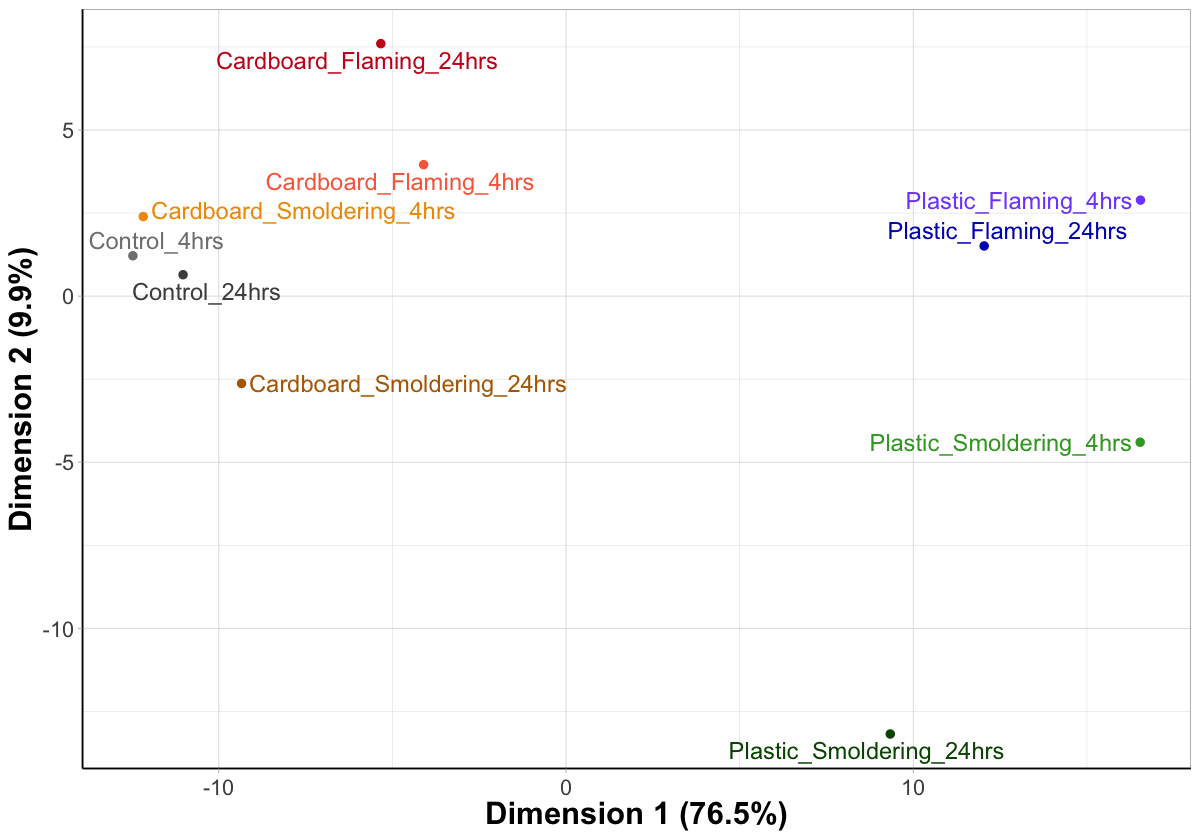

In [9]:
options(repr.plot.width=10, repr.plot.height=7) #changing size
Figure3 = ggplot(data = full_eigenvector_df %>% filter(Biomarker == "mRNA"), 
       aes(x = Avg_PC1, y = Avg_PC2, color = Sample_ID)) + 
  geom_point(size = 2) + 
  geom_text_repel(aes(label = Sample_ID), size = 5) + 

  theme_light() + 
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour="black"), #making x and y axes black
        axis.text = element_text(size = 13), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        legend.position = 'none',
        strip.text.x = element_text(size = 18, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 18, face = "bold")) + #changes size of facet y axis 
  labs(x = 'Dimension 1 (76.5%)', y = 'Dimension 2 (9.9%)') + #changing axis labels 

  scale_color_manual(values = c('#cb181d','#fb6a4a', # cardboard flaming
                             "#b56800", "#f09900", # cardboard smoldering
                             "#4d4d4d", "#808080", # controls
                              '#0000c1','#7f52ff', # cardboard flaming
                             "#005200", "#3aa22b")) # cardboard smoldering  
Figure3

# Cytokine PCA

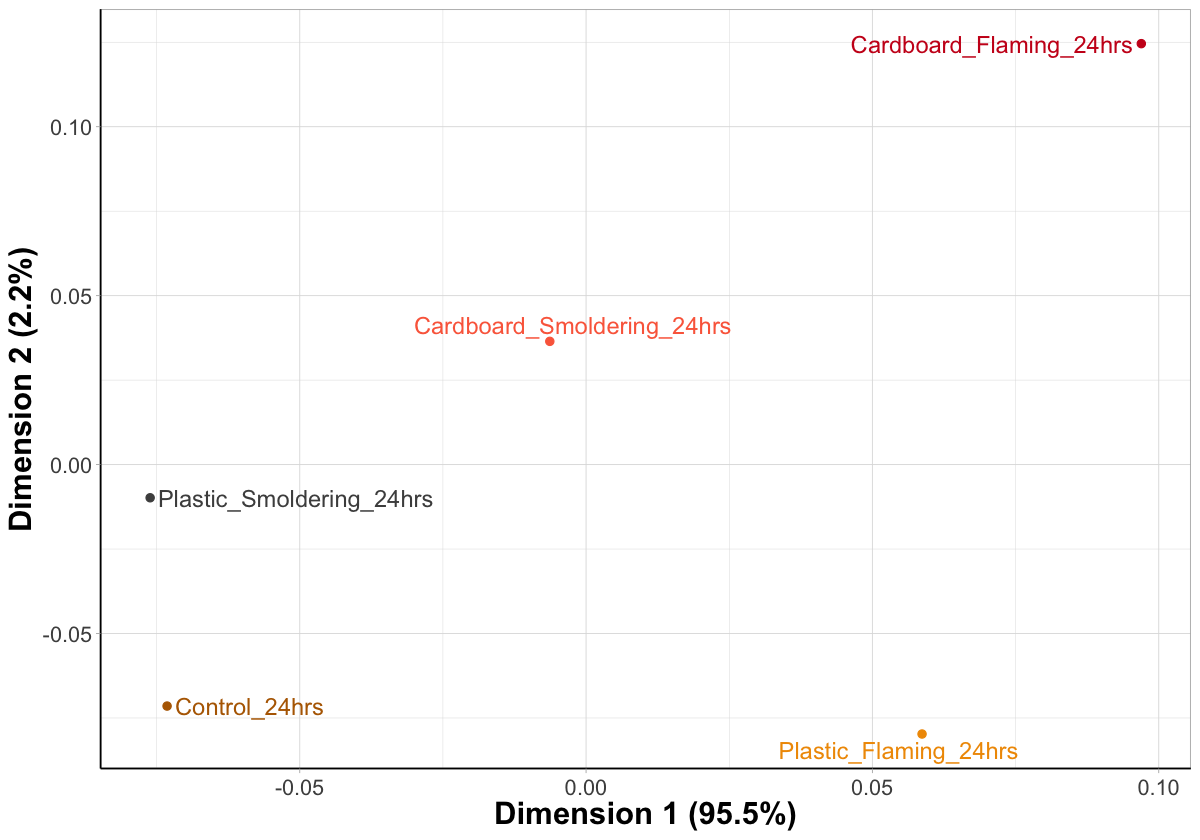

In [10]:
Figure2a = ggplot(data = full_eigenvector_df %>% filter(Biomarker == "Cytokine"), 
       aes(x = Avg_PC1, y = Avg_PC2, color = Sample_ID)) + 
  geom_point(size = 2) + 
  geom_text_repel(aes(label = Sample_ID), size = 5) + 

  theme_light() + 
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour="black"), #making x and y axes black
        axis.text = element_text(size = 13), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        legend.position = 'none',
        strip.text.x = element_text(size = 18, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 18, face = "bold")) + #changes size of facet y axis 
  labs(x = 'Dimension 1 (76.5%)', y = 'Dimension 2 (9.9%)') + #changing axis labels 
  xlab('Dimension 1 (95.5%)') + ylab('Dimension 2 (2.2%)') + #changing axis labels 

scale_color_manual(values = c('#cb181d','#fb6a4a', # cardboard flaming
                             "#b56800", "#f09900", # cardboard smoldering
                             "#4d4d4d", "#808080", # controls
                              '#0000c1','#7f52ff', # cardboard flaming
                             "#005200", "#3aa22b")) # cardboard smoldering  

Figure2a

# Hierarchical Clustering

In [11]:
# determining average gene and cytokine concentrations to order the df for the heat map
avg_mRNA_df = mRNA_df %>%
    # keeping 4,24 hr time point, removing concentration of 5 and 1
    filter(Time_Point %in% c(4,24), Concentration %in% c(25,NA)) %>%
    unite("Sample_ID", c(colnames(mRNA_df)[c(4:7)]), remove = FALSE) %>%
    # normalizing first within each biomarker
    group_by(mRNA) %>%
    mutate(Scaled_Norm_ddCT = scale(Norm_ddCT)) %>%
    ungroup() %>%
    group_by(Time_Point, Sample_ID, mRNA) %>%
    summarize(Avg_Norm_ddCT = mean(Scaled_Norm_ddCT)) %>%
    # now taking overall average
    group_by(Time_Point,Sample_ID) %>%
    summarize(Avg_Norm_ddCT = mean(Avg_Norm_ddCT)) %>%
    # cleaning up sample id names for plotting
    mutate(Sample_ID = ifelse(Sample_ID == "C_F_25_24", "Cardboard_Flaming_24hrs",
                            ifelse(Sample_ID == "C_S_25_24", "Cardboard_Smoldering_24hrs",
                                ifelse(Sample_ID == "PBS_PBS_NA_24", "Control_24hrs",
                                    ifelse(Sample_ID == "P_F_25_24", "Plastic_Flaming_24hrs", 
                                         ifelse(Sample_ID == "P_S_25_24", "Plastic_Smoldering_24hrs",
                                            ifelse(Sample_ID == "C_F_25_4", "Cardboard_Flaming_4hrs",
                                                ifelse(Sample_ID == "C_S_25_4", "Cardboard_Smoldering_4hrs",
                                                    ifelse(Sample_ID == "PBS_PBS_NA_4", "Control_4hrs",
                                                        ifelse(Sample_ID == "P_F_25_4", "Plastic_Flaming_4hrs", 
                                                             ifelse(Sample_ID == "P_S_25_4", "Plastic_Smoldering_4hrs",
                                           NA))))))))))) %>%
    ungroup() %>%
    group_by(Time_Point) %>%
    arrange(Time_Point, -Avg_Norm_ddCT)

avg_cytokine_df = cytokine_df %>%
    # removing concentration of 5 and 1
    filter(Condensate_Conc %in% c(25,NA)) %>%
    unite("Sample_ID", c(colnames(cytokine_df)[c(4:6)]), remove = FALSE) %>%
    # normalizing first within each biomarker
    group_by(Cytokine) %>%
    mutate(Scaled_Conc = scale(Norm_Cytokine_Conc)) %>%
    ungroup() %>%
    group_by(Sample_ID, Cytokine) %>%
    summarize(Avg_Norm_Conc = mean(Scaled_Conc)) %>%
    # now taking overall average
    group_by(Sample_ID) %>%
    summarize(Avg_Norm_Conc = mean(Avg_Norm_Conc)) %>%
    # cleaning up sample id names for plotting
    mutate(Sample_ID = ifelse(Sample_ID == "C_F_25", "Cardboard_Flaming_24hrs",
                            ifelse(Sample_ID == "C_S_25", "Cardboard_Smoldering_24hrs",
                                ifelse(Sample_ID == "PBS_PBS_NA", "Control_24hrs",
                                    ifelse(Sample_ID == "P_F_25", "Plastic_Flaming_24hrs", 
                                         ifelse(Sample_ID == "P_S_25", "Plastic_Smoldering_24hrs",
                                             NA)))))) %>%

    arrange(-Avg_Norm_Conc)

head(avg_mRNA_df)
head(avg_cytokine_df)

ordered_mRNA_samples = avg_mRNA_df$Sample_ID
ordered_cytokine_samples = avg_cytokine_df$Sample_ID

`summarise()` has grouped output by 'Time_Point', 'Sample_ID'. You can override
using the `.groups` argument.
`summarise()` has grouped output by 'Time_Point'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'Sample_ID'. You can override using the
`.groups` argument.


Time_Point,Sample_ID,Avg_Norm_ddCT
<dbl>,<chr>,<dbl>
4,Control_4hrs,0.5468453
4,Cardboard_Smoldering_4hrs,0.5287902
4,Cardboard_Flaming_4hrs,0.2329417
4,Plastic_Smoldering_4hrs,-0.8101327
4,Plastic_Flaming_4hrs,-0.8153052
24,Control_24hrs,0.4860961


Sample_ID,Avg_Norm_Conc
<chr>,<dbl>
Plastic_Smoldering_24hrs,0.05368766
Cardboard_Smoldering_24hrs,0.02207315
Control_24hrs,0.01150326
Plastic_Flaming_24hrs,-0.04065345
Cardboard_Flaming_24hrs,-0.04661062


In [12]:
# creating a wider df for plotting that contains sample ids, biomarkers, avg concentrations
mRNA_clustering_df = mRNA_df %>%
    # keeping 4,24 hr time point, removing concentration of 5 and 1
    filter(Time_Point %in% c(4,24), Concentration %in% c(25,NA)) %>%
    unite("Sample_ID", c(colnames(mRNA_df)[c(4:7)]), remove = FALSE) %>%
    # normalizing first within each biomarker
    group_by(mRNA) %>%
    mutate(Scaled_Norm_ddCT = scale(Norm_ddCT)) %>%
    ungroup() %>%
    group_by(Time_Point, Sample_ID, mRNA) %>%
    summarize(Avg_Norm_ddCT = mean(Scaled_Norm_ddCT)) %>%
    # cleaning up sample id names for plotting
    mutate(Sample_ID = ifelse(Sample_ID == "C_F_25_24", "Cardboard_Flaming_24hrs",
                            ifelse(Sample_ID == "C_S_25_24", "Cardboard_Smoldering_24hrs",
                                ifelse(Sample_ID == "PBS_PBS_NA_24", "Control_24hrs",
                                    ifelse(Sample_ID == "P_F_25_24", "Plastic_Flaming_24hrs", 
                                         ifelse(Sample_ID == "P_S_25_24", "Plastic_Smoldering_24hrs",
                                            ifelse(Sample_ID == "C_F_25_4", "Cardboard_Flaming_4hrs",
                                                ifelse(Sample_ID == "C_S_25_4", "Cardboard_Smoldering_4hrs",
                                                    ifelse(Sample_ID == "PBS_PBS_NA_4", "Control_4hrs",
                                                        ifelse(Sample_ID == "P_F_25_4", "Plastic_Flaming_4hrs", 
                                                             ifelse(Sample_ID == "P_S_25_4", "Plastic_Smoldering_4hrs",
                                           NA)))))))))),
    # renaming a gene
    mRNA = ifelse(mRNA == "GMCSF2", "CSF2", mRNA)) %>%
    ungroup() %>%
    group_by(Time_Point) %>%
    group_split() 

# creating separate dfs for each time point
mRNA_clustering_4hr_df = mRNA_clustering_df[[1]] %>%
    pivot_wider(names_from = Sample_ID, values_from = Avg_Norm_ddCT) %>%
    column_to_rownames(var = "mRNA") %>%
    select(-Time_Point)
mRNA_clustering_24hr_df = mRNA_clustering_df[[2]] %>%
    pivot_wider(names_from = Sample_ID, values_from = Avg_Norm_ddCT) %>%
    column_to_rownames(var = "mRNA") %>%
    select(-Time_Point)

mRNA_clustering_4hr_df = mRNA_clustering_4hr_df[,ordered_mRNA_samples[1:5]]
mRNA_clustering_24hr_df = mRNA_clustering_24hr_df[,ordered_mRNA_samples[6:10]]

head(mRNA_clustering_4hr_df)
head(mRNA_clustering_24hr_df)

`summarise()` has grouped output by 'Time_Point', 'Sample_ID'. You can override
using the `.groups` argument.


,Control_4hrs,Cardboard_Smoldering_4hrs,Cardboard_Flaming_4hrs,Plastic_Smoldering_4hrs,Plastic_Flaming_4hrs
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ALDH1A3,0.7501878,0.8242370,0.1931561,-1.0418278,-1.3605622
ALDH3A1,0.8006779,0.8997774,0.5366157,-1.2511973,-1.2832213
CXCL1,0.6214845,0.6837442,0.2926537,-0.7139424,-0.8065656
CXCR1,-0.2051319,-0.2616321,0.4081479,-0.2983605,-0.3109166
CYP1A1,1.1854555,0.8826210,-0.7181153,-0.9992187,-1.0535926
CYP1B1,0.9937590,0.8839872,-0.2427637,-0.9055622,-1.2811451


,Control_24hrs,Cardboard_Smoldering_24hrs,Cardboard_Flaming_24hrs,Plastic_Smoldering_24hrs,Plastic_Flaming_24hrs
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ALDH1A3,0.8310722,0.6056220,0.5345277,-0.51055997,-0.8258529
ALDH3A1,0.8024365,0.6596127,0.5600107,-0.89088488,-0.8338274
CXCL1,0.6439633,0.3671311,0.2365099,-0.41345594,-0.9115229
CXCR1,-0.2524626,0.4001223,0.3963454,-0.29202827,0.4159165
CYP1A1,1.2041982,0.7898720,-0.4927821,0.08901356,-0.8874514
CYP1B1,0.9813363,0.6546394,0.1011876,-0.24529910,-0.9401394


In [13]:
cytokine_clustering_df = cytokine_df %>%
    # removing concentration of 5 and 1
    filter(Condensate_Conc %in% c(25,NA)) %>%
    unite("Sample_ID", c(colnames(cytokine_df)[c(4:6)]), remove = FALSE) %>%
    # normalizing first within each biomarker
    group_by(Cytokine) %>%
    mutate(Norm_Cytokine_Conc = scale(Norm_Cytokine_Conc)) %>%
    ungroup() %>%
    group_by(Cytokine, Sample_ID) %>%
    summarize(Avg_Norm_Conc = mean(Norm_Cytokine_Conc)) %>%
    # cleaning up sample id names for plotting
    mutate(Sample_ID = ifelse(Sample_ID == "C_F_25", "Cardboard_Flaming_24hrs",
                            ifelse(Sample_ID == "C_S_25", "Cardboard_Smoldering_24hrs",
                                ifelse(Sample_ID == "PBS_PBS_NA", "Control_24hrs",
                                    ifelse(Sample_ID == "P_F_25", "Plastic_Flaming_24hrs", 
                                         ifelse(Sample_ID == "P_S_25", "Plastic_Smoldering_24hrs",
                                             NA)))))) %>%
    pivot_wider(names_from = Sample_ID, values_from = Avg_Norm_Conc) %>%
    column_to_rownames(var = "Cytokine")

# ordering cytokines for heat map
# ordering the cytoines by avg value didn't make a difference, so I used the same order from the mRNAs
cytokine_clustering_df = cytokine_clustering_df[,ordered_mRNA_samples[6:10]]

head(cytokine_clustering_df)

`summarise()` has grouped output by 'Cytokine'. You can override using the
`.groups` argument.


,Control_24hrs,Cardboard_Smoldering_24hrs,Cardboard_Flaming_24hrs,Plastic_Smoldering_24hrs,Plastic_Flaming_24hrs
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Eotaxin3,0.07944425,0.04250676,-0.2880900,0.03661786,0.12952110
GMCSF,-0.83491472,-0.11345550,0.7134418,0.17424974,0.06067871
IL10,0.26528028,-0.33523997,-0.1864820,-0.15242785,0.40886957
IL13,0.54898560,-0.07349532,-0.2171842,-0.30267546,0.04436938
IL15,-0.66712231,0.50774247,0.1024614,0.21479845,-0.15788002
IL1a,-0.36590514,-0.10773601,0.8726052,-0.28629508,-0.11266897


# Cytokine Heat Map

The samples on the x axis are arranged from highest (left) to lowest (right) average cytokine concentration. The cytokines are y axis are clustered based on their concentrations. 

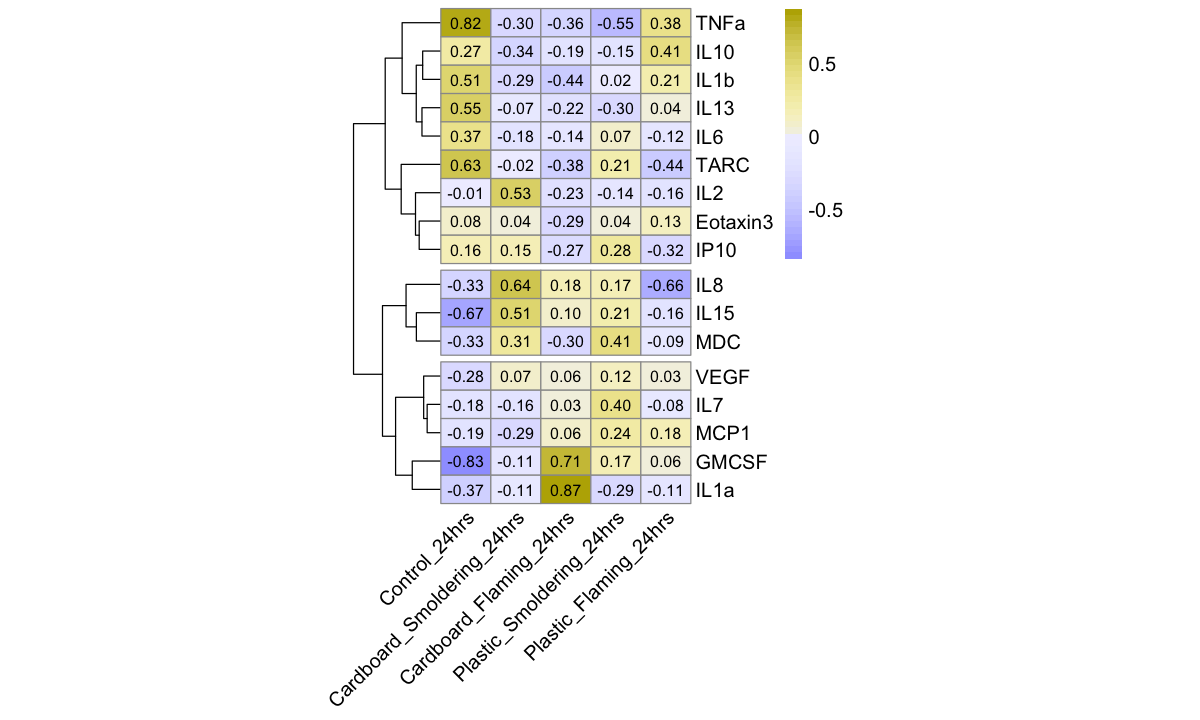

In [14]:
options(repr.plot.width=10, repr.plot.height=6) #changing size
Figure2b = pheatmap(cytokine_clustering_df, cluster_rows = TRUE, cluster_cols = FALSE, 
         angle_col = 45, fontsize = 12,  
         cellheight = 17, cellwidth = 30,
         color = hcl.colors(40, "Blue-Yellow 3"),
         display_numbers = TRUE, number_color = "black", 
         cutree_row = 3) # adds a break bewtween the largest clusters

# mRNA Heat Maps

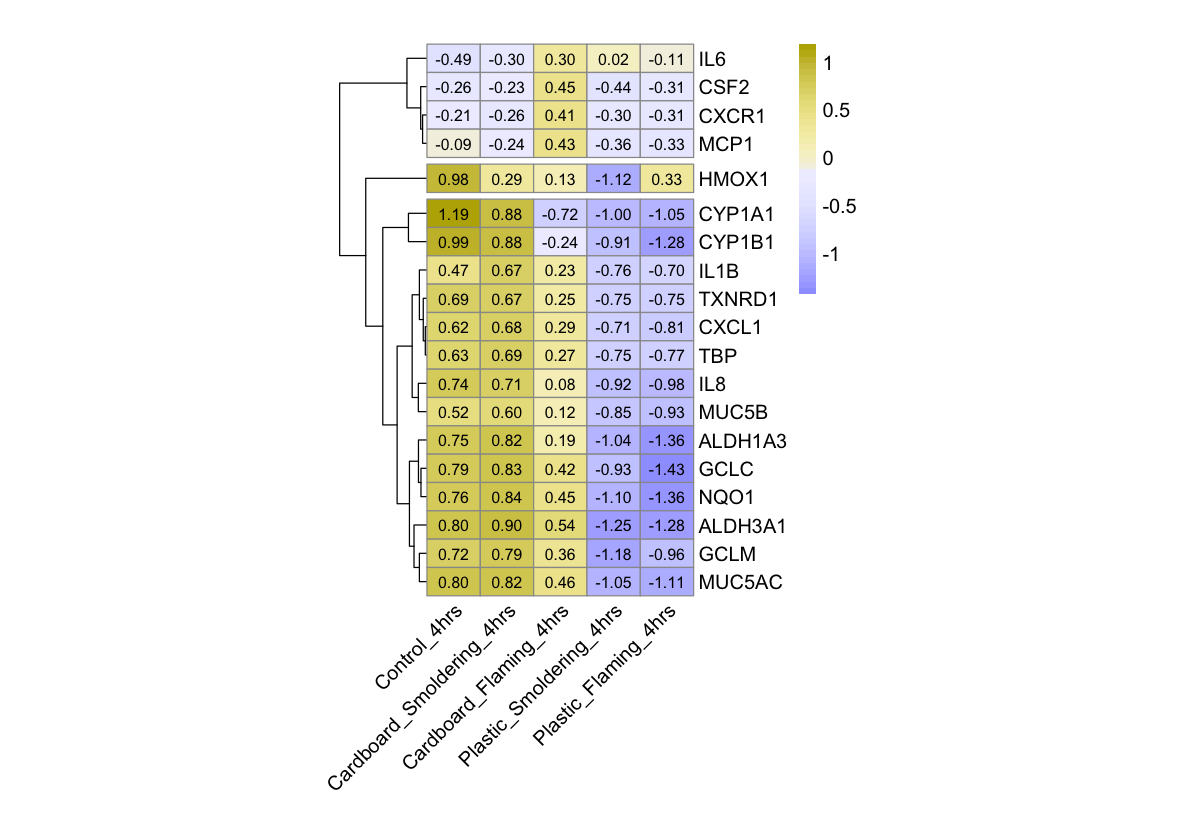

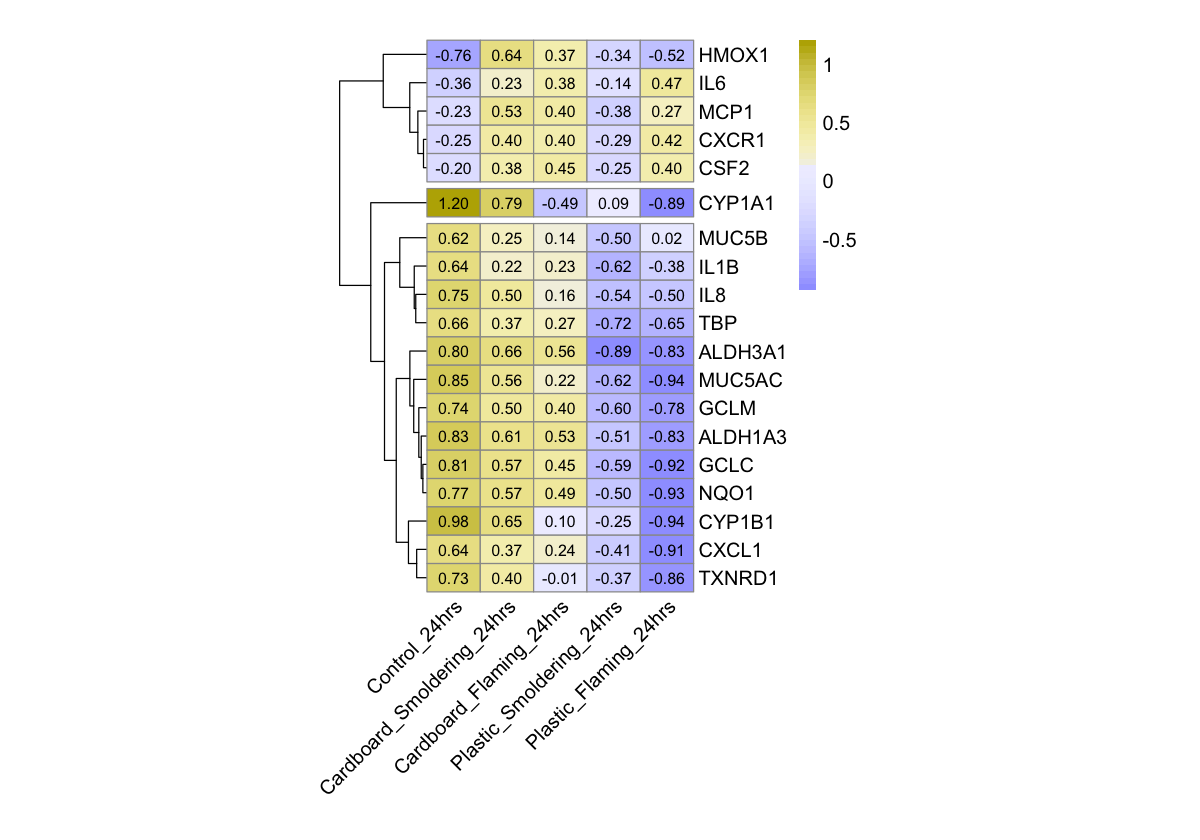

In [15]:
options(repr.plot.width=10, repr.plot.height=7) #changing size
Figure4a = pheatmap(mRNA_clustering_4hr_df, cluster_rows = TRUE, cluster_cols = FALSE, 
         angle_col = 45, fontsize = 12,  
         cellheight = 17, cellwidth = 32,
         color = hcl.colors(40, "Blue-Yellow 3"), 
         display_numbers = TRUE, number_color = "black", 
         cutree_row = 3) # adds a break bewtween the largest clusters

Figure4b = pheatmap(mRNA_clustering_24hr_df, cluster_rows = TRUE, cluster_cols = FALSE, 
         angle_col = 45, fontsize = 12,  
         cellheight = 17, cellwidth = 32,
         color = hcl.colors(40, "Blue-Yellow 3"),
         display_numbers = TRUE, number_color = "black", 
         cutree_row = 3) # adds a break bewtween the largest clusters

# Figure 2

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]

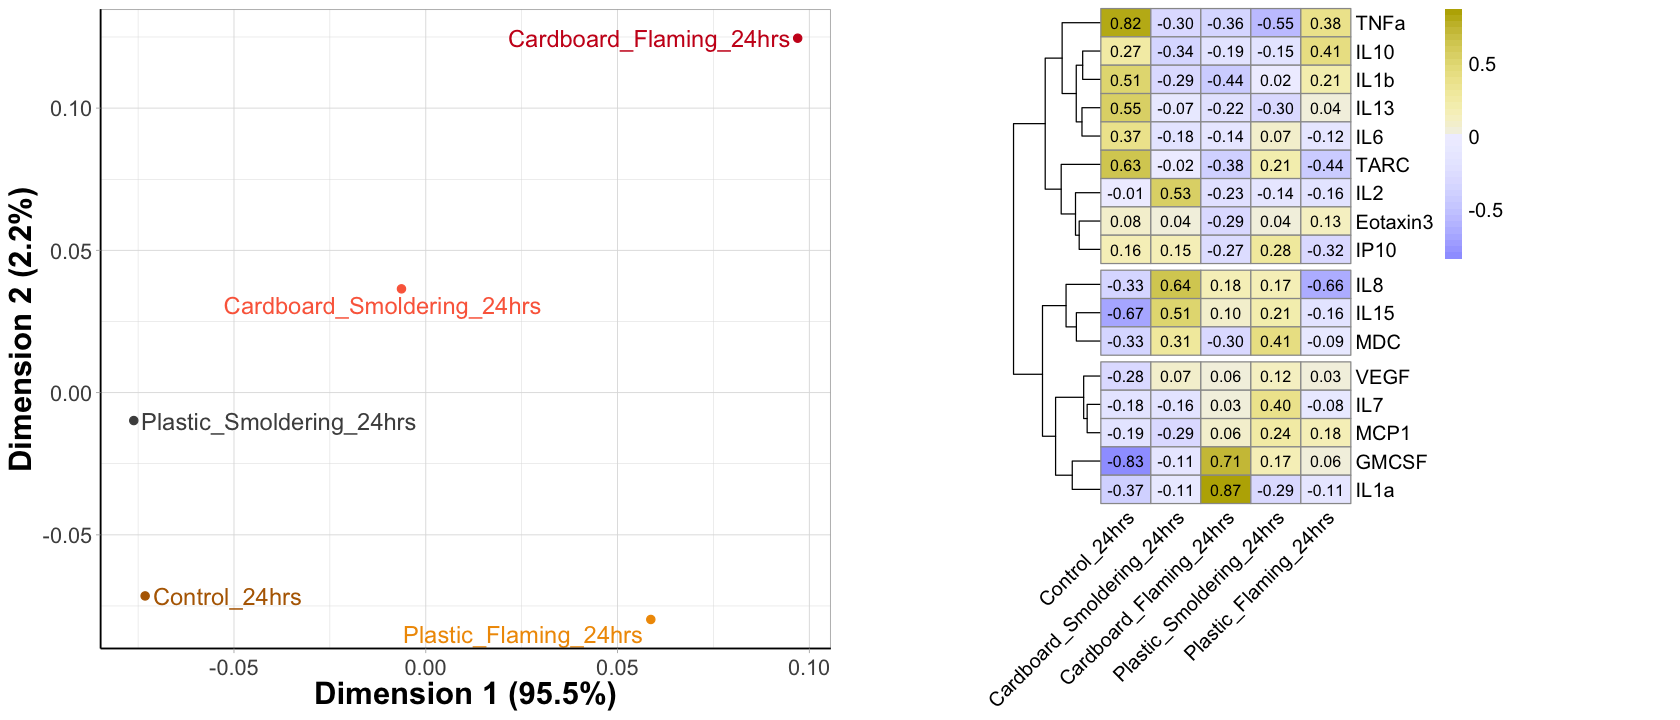

In [16]:
options(repr.plot.width=14, repr.plot.height=6) #changing size
# creating 1 figure
Figure2 = grid.arrange(Figure2a, Figure2b[[4]], ncol = 2)
Figure2

# Figure 4

TableGrob (1 x 2) "arrange": 2 grobs
         z     cells    name           grob
Figure4a 1 (1-1,1-1) arrange gtable[layout]
Figure4b 2 (1-1,2-2) arrange gtable[layout]

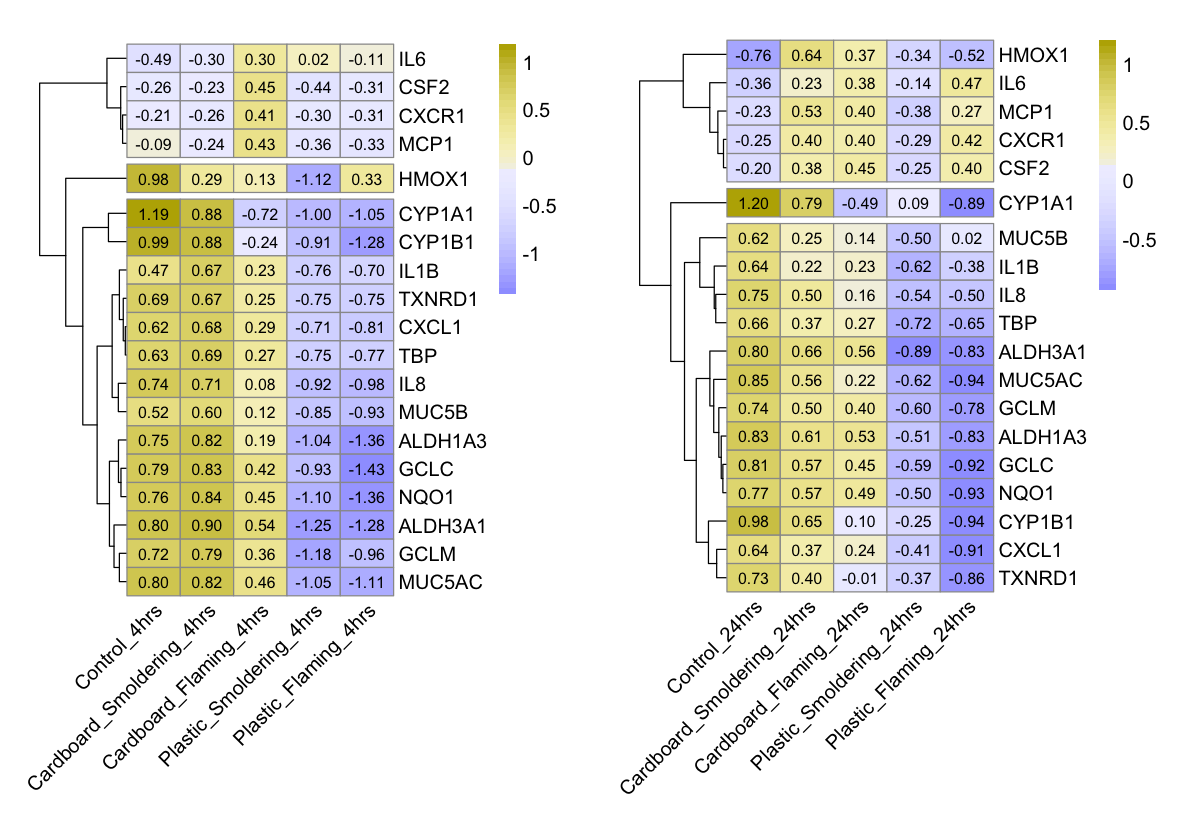

In [17]:
options(repr.plot.width=10, repr.plot.height=7) #changing size
# creating 1 figure
plot_list = list()
plot_list[['Figure4a']] = Figure4a[[4]]
plot_list[['Figure4b']] = Figure4b[[4]]

Figure4 = grid.arrange(grobs = plot_list, ncol = 2)
Figure4

In [18]:
# exporting figures
ggsave(Figure2, 
       filename = 'Figure 2.pdf',
       path = Output,
       width = 14, height = 6)
ggsave(Figure3, 
       filename = 'Figure 3.pdf',
       path = Output,
       width = 10, height = 7)
ggsave(Figure4, 
       filename = 'Figure 4.pdf',
       path = Output,
       width = 10, height = 7)